In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

result_path = 'RESULT/MEAN/*csv'
files = [x for x in glob.glob(result_path)]
files

/var/folders/88/f54vzxs97213ybfz7_k_npl00000gn/T/ipykernel_82388/2495963192.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


['RESULT/MEAN/t5-small.csv', 'RESULT/MEAN/bart.csv', 'RESULT/MEAN/t5-base.csv']

In [2]:
result_path = 'RESULT/STD/*csv'
files_std = [x for x in glob.glob(result_path)]
files_std

['RESULT/STD/t5-base.csv']

In [3]:
dfs={}
for file in files:
    dfs[file.split('/')[-1].replace('.csv','')] = pd.read_csv(file)
dfs_std={}
for file in files_std:
    dfs_std[file.split('/')[-1].replace('.csv','')] = pd.read_csv(file)

# columns = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective',
#        'Nuclearity', 'Relation', 'EDU segmentation', 'Cloze', 'Average']
columns = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective', 'Cloze', 'Average']
dfs.keys()
# models = ['bert', 'roberta', 'albert', 'gpt2', 'electra','bart', 't5' ]
models = ['t5-base', 't5-small', 'bart']

In [4]:
dfs_std.keys()

dict_keys(['t5-base'])

In [5]:
from collections import defaultdict
import numpy as np

def normalize(arr):
    new_tupple = []
    max_score = arr[0][1]
    min_score = arr[-1][1]
    for idx in range(len(arr)):
        new_score = (arr[idx][1] - min_score) / (max_score-min_score)
        new_tupple.append((arr[idx][0],new_score))
    return new_tupple


def get_dict_back(tuples):
    ret = {}
    for model_layer, rr in tuples:
        ret[model_layer]  =rr
    return ret


# cols = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective',
#        'Nuclearity', 'Relation', 'EDU segmentation', 'Cloze']
cols = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective', 'Cloze']

new_dfs = {}
for model in models:
    new_dfs[model] = pd.DataFrame()
print(dfs)
for col in cols:
    #if col in ['Nuclearity', 'Relation']:
    #    continue
    data = defaultdict(list)
    for idx in range(6):
        for model in models:
            key = model+'-'+str(idx)
            data[key] = dfs[model].iloc[idx][col]
    to_sort=sorted(data.items(), key=lambda x: x[1], reverse=True)        
    print(to_sort)
    to_sort=normalize(to_sort)
    print(to_sort)
    data=get_dict_back(to_sort)
    print(data)
    
    col_name = col+'_rank'
    for model in models:
        new_data = []
        for idx in range(6):
            new_data.append(data[model+'-'+str(idx)])
        new_dfs[model][col_name]=new_data

for model in models:
    dfs[model]['Average of Normalized Scores']= new_dfs[model].mean(1).tolist()

{'t5-small':    Layer  Discourse Connective  NSP with 4 MC  Sent. Ordering  Cloze  \
0      1                  0.39           0.77            0.27   0.71   
1      2                  0.43           0.80            0.30   0.70   
2      3                  0.45           0.82            0.32   0.73   
3      4                  0.46           0.84            0.33   0.74   
4      5                  0.45           0.87            0.33   0.72   
5      6                  0.45           0.86            0.35   0.72   

   Unnamed: 5  Unnamed: 6  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN  
5         NaN         NaN  , 'bart':    Layer  Discourse Connective  NSP with 4 MC  Sent. Ordering  Cloze  \
0      1                  0.48           0.86            0.30   0.73   
1      2                  0.49           0.92            0.34   0.76   
2      3                  0.51           0.95            0.35

In [6]:
from collections import defaultdict
import numpy as np

# Higher rank is better
def get_rank(arr):
    new_tupple = []
    cur_rank = 1
    cur_score = arr[0][1]
    for idx in range(len(arr)):
        if arr[idx][1] != cur_score:
            assert cur_score > arr[idx][1]
            cur_rank=idx+1
            cur_score = arr[idx][1]
        new_tupple.append((arr[idx][0],1/(cur_rank+1)))
    return new_tupple

def get_dict_back(tuples):
    ret = {}
    for model_layer, rr in tuples:
        ret[model_layer]  =rr
    return ret


# cols = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective',
#        'Nuclearity', 'Relation', 'EDU segmentation', 'Cloze']
cols = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective', 'Cloze']

new_dfs = {}
for model in models:
    new_dfs[model] = pd.DataFrame()

for col in cols:
    #if col in ['Nuclearity', 'Relation']:
    #    continue
    data = defaultdict(list)
    for idx in range(6):
        for model in models:
            key = model+'-'+str(idx)
            data[key] = dfs[model].iloc[idx][col]
    to_sort=sorted(data.items(), key=lambda x: x[1], reverse=True)        
    to_sort=get_rank(to_sort)
    data=get_dict_back(to_sort)
    
    col_name = col+'_rank'
    for model in models:
        new_data = []
        for idx in range(6):
            new_data.append(data[model+'-'+str(idx)])
        new_dfs[model][col_name]=new_data

for model in models:
    dfs[model]['Average Reciprocal Rank (Global)']= new_dfs[model].mean(1).tolist()

In [7]:
# title2index = {'NSP with 4 MC': [0,0], 'Sent. Ordering': [0,1], 'Discourse Connective': [0,2],
#        'Nuclearity': [1,0], 'Relation': [1,1], 'EDU segmentation': [1,2], 'Cloze': [2,0], 'Average of Normalized Scores': [2,1], 'Average Reciprocal Rank (Global)': [2,2]}

title2index = {'NSP with 4 MC': [0,0], 'Sent. Ordering': [0,1], 'Discourse Connective': [0,2], 'Cloze': [1,0], 'Average of Normalized Scores': [1,1]}

# title2xlabel = {'NSP with 4 MC': 'Accuracy', 'Sent. Ordering': 'Spearman Rank', 'Discourse Connective': 'Accuracy',
#        'Nuclearity': 'Accuracy', 'Relation': 'Accuracy', 'EDU segmentation': 'F1-macro', 'Cloze': 'Accuracy', 'Average of Normalized Scores': 'Score', 'Average Reciprocal Rank (Global)': 'Reciprocal Rank'}

title2xlabel = {'NSP with 4 MC': 'Accuracy', 'Sent. Ordering': 'Spearman Rank', 'Discourse Connective': 'Accuracy', 'Cloze': 'Accuracy', 'Average of Normalized Scores': 'Score'}

# model2color = {'t5': 'orange', 'bert': 'red', \
#                'bart': 'green', 'gpt2': 'black', 'electra': 'blue', 'roberta': '#46bdc6', 'albert': 'purple'}

model2color = {'t5-small': '#f07c02', 'bart': 'green', 't5-base': 'purple'}

# model2label = {'t5': 'T5', 'bert': 'BERT', \
#                'bart': 'BART', 'gpt2': 'GPT-2', 'electra': 'ELECTRA', 'roberta': 'RoBERTa', 'albert': 'ALBERT'}

model2label = {'t5-small': 'T5-Small', 'bart': 'BART', 't5-base': 'T5-Base'}

# model2line = {'t5': '-', 'bert': '-', \
#                'bart': '-', 'gpt2': '-', 'electra': '--', 'roberta': '-', 'albert': '-.'}

model2line = {'t5-small': '-', 'bart': '-', 't5-base': '--'}

# model2marker = {'t5': '^', 'bert': '', \
#                'bart': 'h', 'gpt2': 'v', 'electra': '', 'roberta': 'x', 'albert': ''}

model2marker = {'t5-small': '^', 'bart': 'h', 't5-base': 'v'}

# columns = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective',
#        'Nuclearity', 'Relation', 'EDU segmentation', 'Cloze', 'Average of Normalized Scores','Average Reciprocal Rank (Global)']

columns = ['NSP with 4 MC', 'Sent. Ordering', 'Discourse Connective', 'Cloze', 'Average of Normalized Scores']

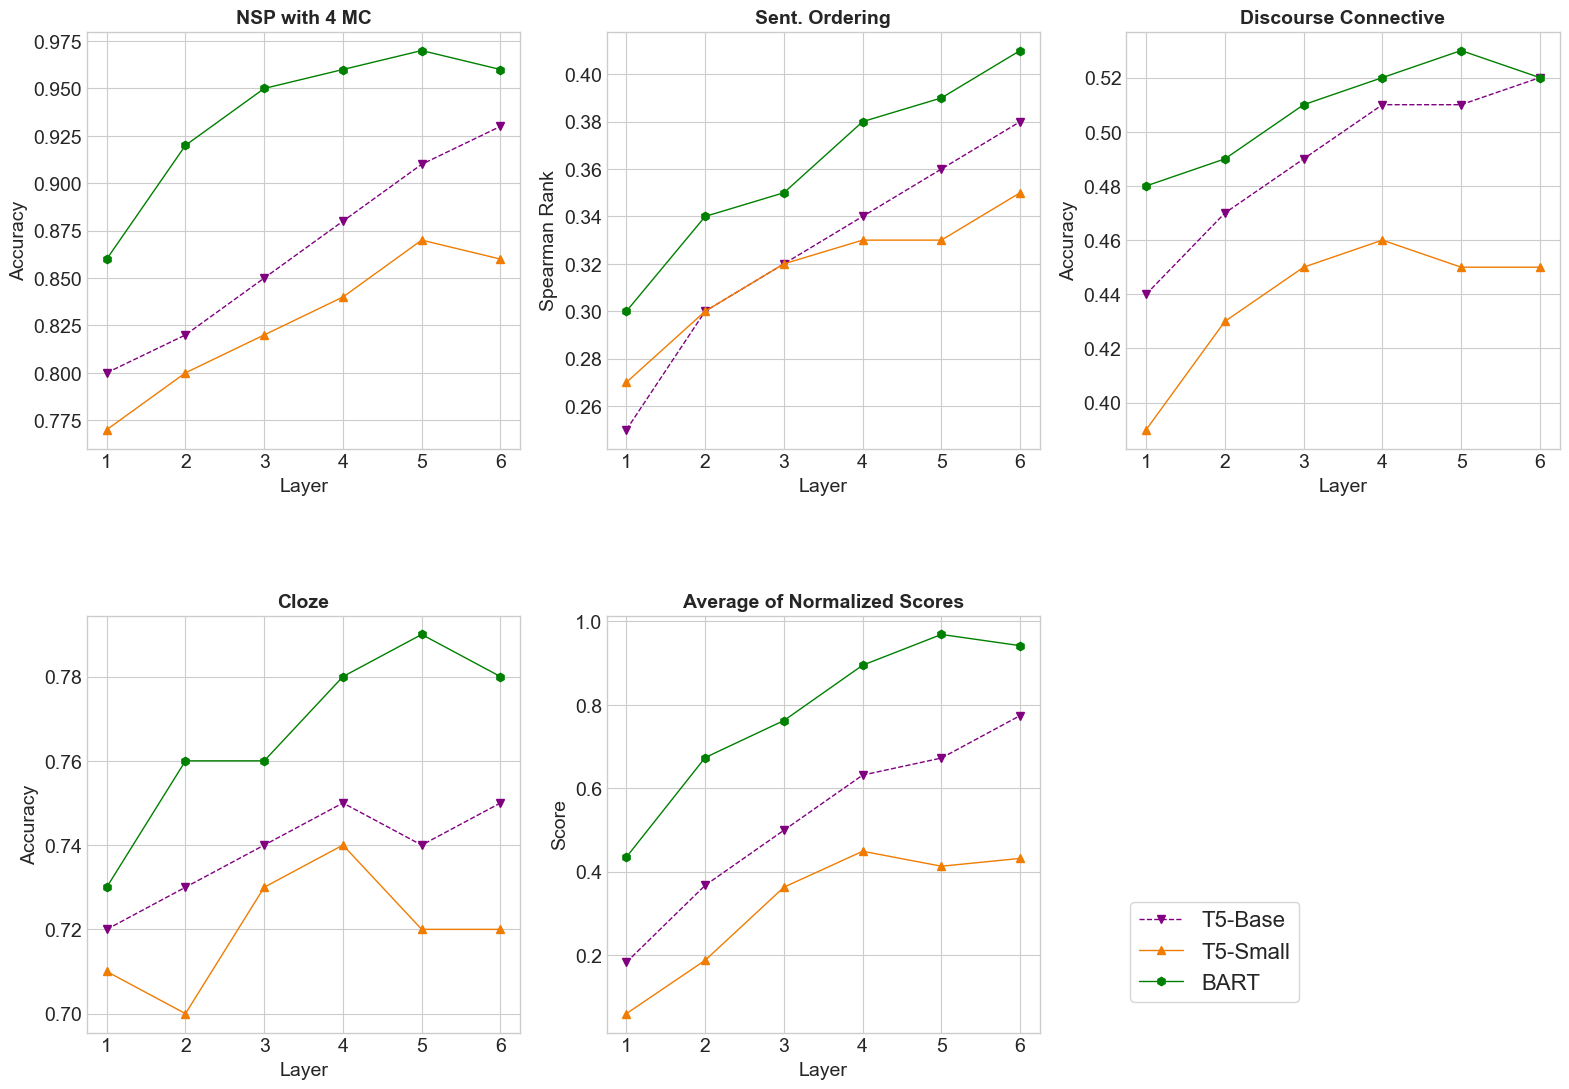

In [8]:
# fig, ax = plt.subplots(3,3,figsize=(19,13))
# fig.delaxes(ax[2][2])
fig, ax = plt.subplots(2,3,figsize=(19,13))
fig.delaxes(ax[1][2])

fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.4)

for title in columns:
    x,y = title2index[title]
    for model in models:
        df = dfs[model]
        if title != 'Average of Normalized Scores':
            # ax[x,y].errorbar(df['Layer'], df[title], yerr=dfs_std[model][title], color=model2color[model], label=model2label[model], 
            #          marker=model2marker[model], linestyle=model2line[model], linewidth=1)
            ax[x,y].errorbar(df['Layer'], df[title], color=model2color[model], label=model2label[model], 
                     marker=model2marker[model], linestyle=model2line[model], linewidth=1)
        elif title == 'Average of Normalized Scores':
            ax[x,y].plot(df['Layer'], df[title], color=model2color[model], label=model2label[model], 
                     marker=model2marker[model], linestyle=model2line[model], linewidth=1)
    ax[x,y].set_title(title, fontsize=14, fontweight='bold')
    ax[x,y].set_xlabel('Layer',fontsize=14)
    ax[x,y].set_ylabel(title2xlabel[title], fontsize=14)
    #ax[x,y].set_ylim(ymin=0)
    #ax[x,y].set_ylim(ymax=1.)
    ax[x,y].tick_params(labelsize=14)
    
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc=(0.72,0.08), frameon=True, fontsize=16)
#fig.legend(lines, labels, loc='lower center', frameon=True, fontsize=16, ncol=7)

#plt.tick_params(labelsize=14)

plt.savefig('across_models_v3.pdf', bbox_inches='tight')